<font size=6 color = "#663399" >Hidden Markov Models (HMM)</font>
- <font size=4>Name: Kasra Noorbakhsh</font>
- <font size=4>SID: 810100230</font>

<font size=6 color = "#663399" >Introduction</font>

<font size=4>In this project, we will explore the application of the Hidden Markov Model (HMM) in the context of specifing the pronounciation of numbers.</font>

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import normalize
import  python_speech_features 
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'librosa'

<font size=6 color = "#663399" >Data set</font>

<font size=4>In our data set we have 6 people saying numbers 0 - 9 for 50 times and each of them are in '{digitLabel} _ {speakerName} _ {index}.wav' syntax. using the code bellow I stored MFCCs of them. I trimmed the data that the duration of the audio is consistent across different recordings and I removed those parts of the voice that was silent.</font>

In [ ]:
directory = 'recordings'
num_of_people = 6
num_of_samples = 50

mfcc_dic_num = {}
mfcc_dic_speaker = {}

for i in range(10):
    mfcc_dic_num[i] = []


for filename in os.listdir(directory):
    if filename.endswith('.wav'):
        parts = filename.split('_')
        digit_label = int(parts[0])
        speaker_name = parts[1]
        index = int(parts[2].split('.')[0])

        audio_file_path = os.path.join(directory, filename)
        data, sampling_rate = librosa.load(audio_file_path)

        data = data[data != 0 ]
        
        mfcc = python_speech_features.mfcc(data, numcep=13, samplerate = sampling_rate, nfft=512)
        
        mfcc = mfcc[ : 22, :]
        mfcc_dic_num[int(parts[0])].append(mfcc)

        if (speaker_name in mfcc_dic_speaker.keys()):
            mfcc_dic_speaker[speaker_name].append(mfcc)
        else: 
            mfcc_dic_speaker[speaker_name] = [mfcc]

<font size=6 color = "#663399" >Preprocessing and Feature Extraction</font>

- <font size=4> <b>segmentation</b>: As it seems segmentation has some benefits but in out data because we have a number in each file and it is only 1 seconds it is not neccessery. It is kinda segmentated because each file contains one number.</font>

- <font size=4> <b>Features of Voice</b>:

1. Chroma Features: Chroma features are representations of the energy distribution of the pitch classes (or chroma) in an audio signal.

2. Mel-spectrogram: A Mel-spectrogram is a representation of the frequency content of an audio signal over time, where the frequencies are converted into the mel scale. The mel scale is a perceptual scale of pitches that approximates the human auditory system's response to different frequencies.

3. Zero Crossing Rate (ZCR): The zero-crossing rate is a simple feature that counts the number of times the audio waveform crosses the zero axis within a given time frame.

4. Mel-frequency cepstral coefficients (MFCC): MFCCs are derived from the power spectrum of an audio signal after it has been transformed into the mel scale. MFCCs represent the short-term power spectrum of a sound in a compact form by discarding certain less important information.

- Chroma Features vs. MFCC: While both are derived from the Fourier Transform, chroma features focus on the distribution of energy in pitch classes, while MFCCs capture information about the overall spectral shape of the signal. 

- Mel-spectrogram and MFCC: MFCCs are often derived from the Mel-spectrogram. The Mel-spectrogram provides a spectral representation of the signal in the mel scale, which is then used to compute the MFCCs. MFCCs capture more compact information about the spectral characteristics of the signal compared to the full Mel-spectrogram.</font>

<font size=4>Let's plot the MFCCs of one sample from each number</font>

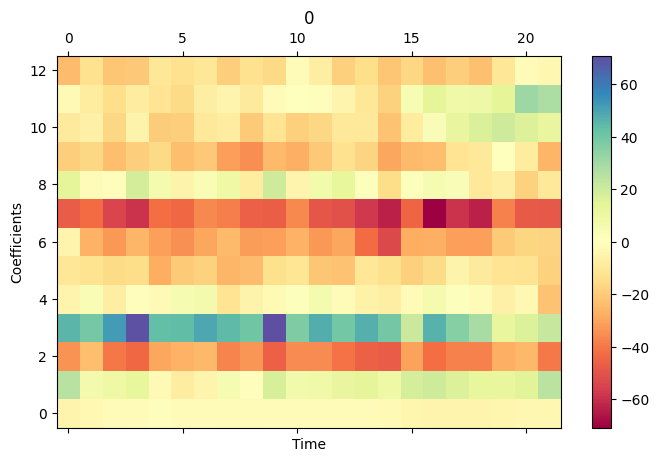

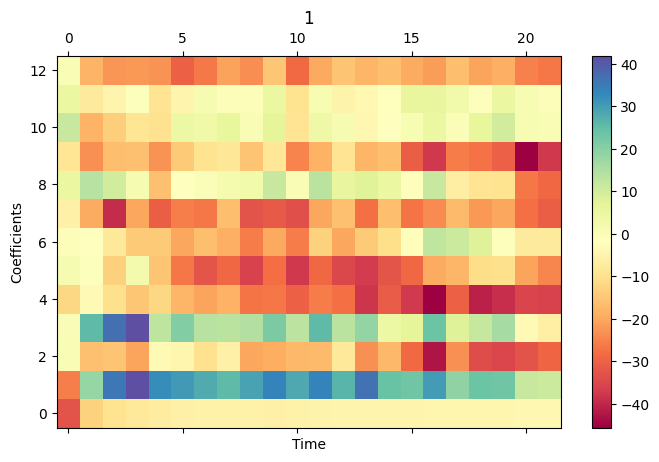

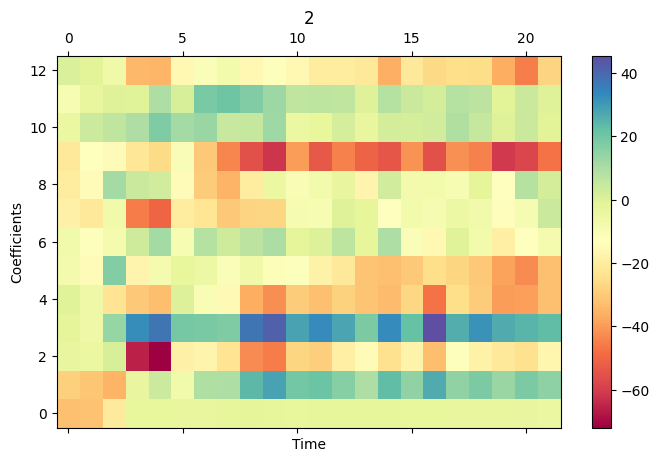

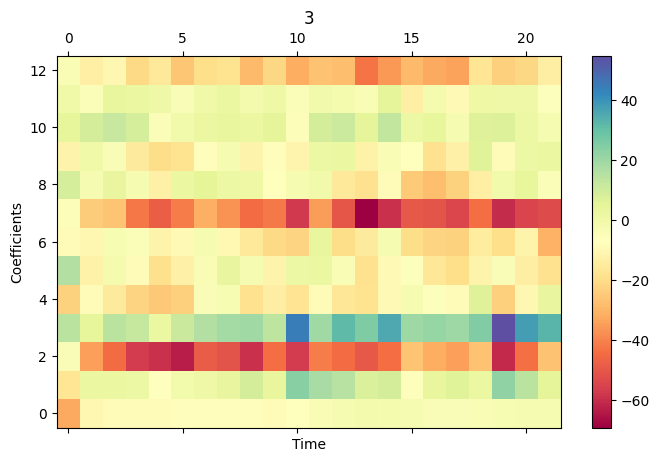

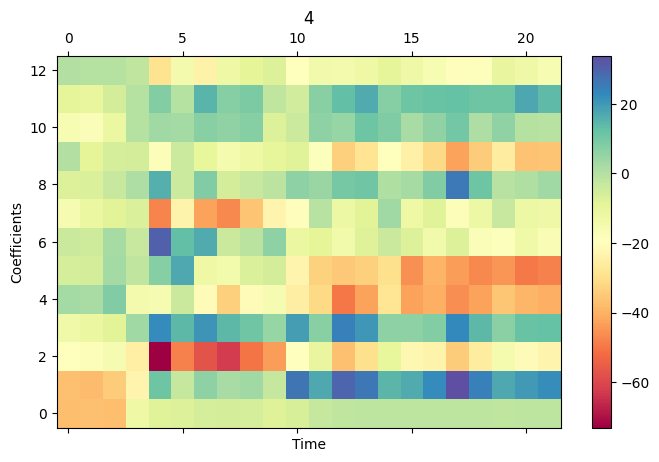

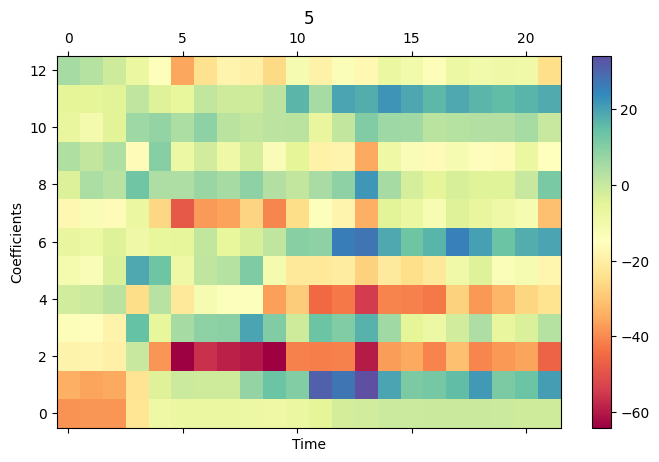

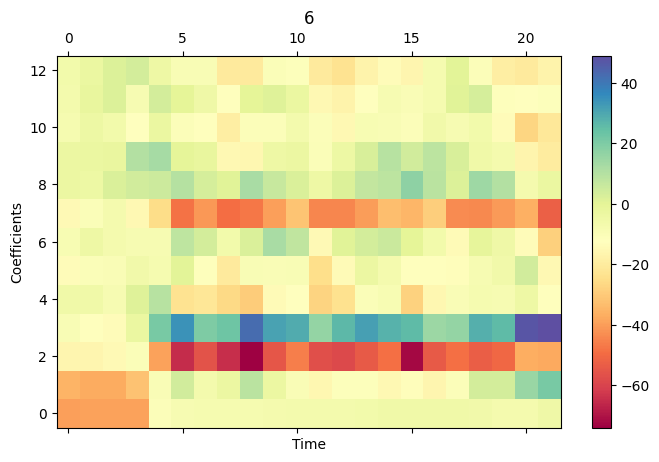

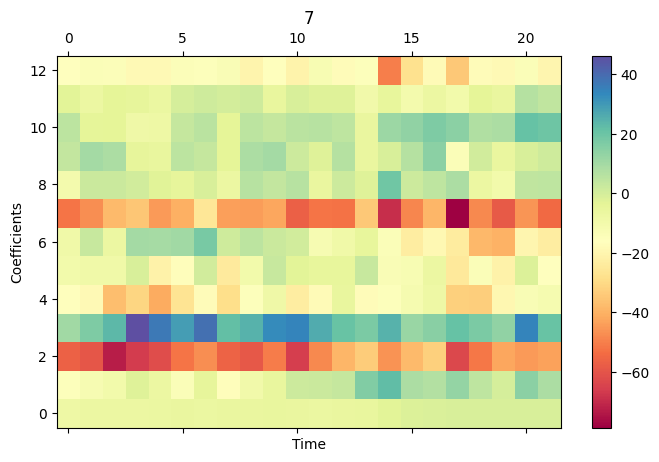

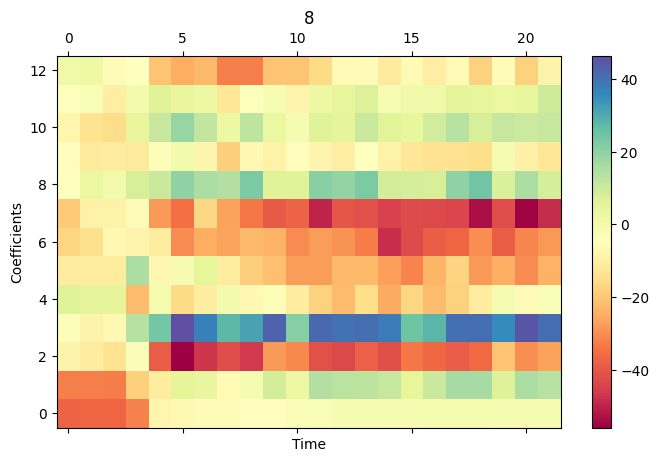

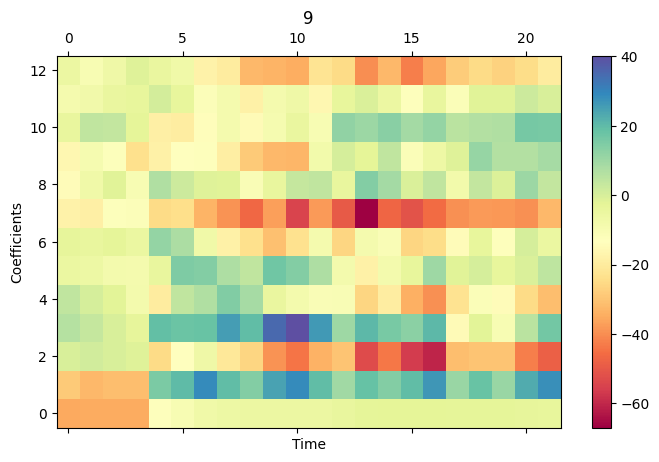

In [ ]:
for i in range(10):
    plt.matshow(mfcc_dic_num[i][0].T, cmap='Spectral', origin='lower', aspect='auto')
    plt.title(f"{i}")
    plt.ylabel('Coefficients')
    plt.xlabel('Time')
    plt.colorbar()
    plt.show()

<font size=4>Let's plot the MFCCs of one sample from each speaker</font>

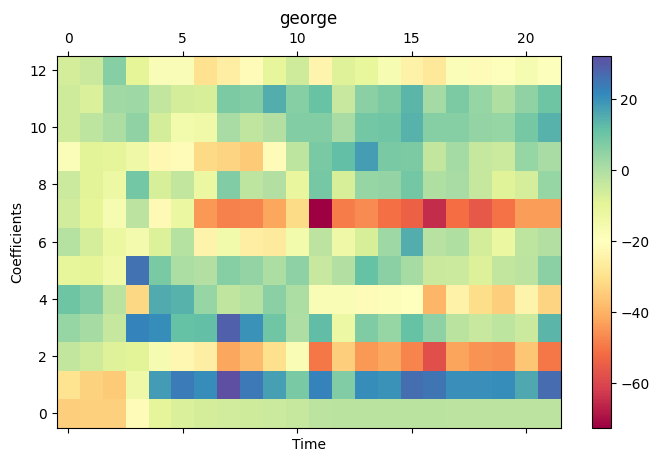

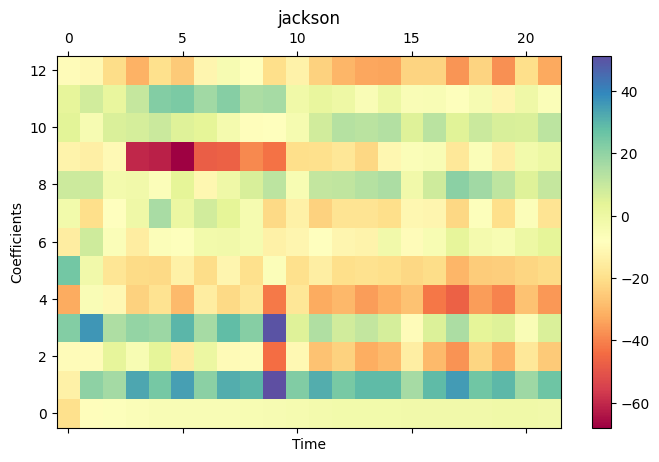

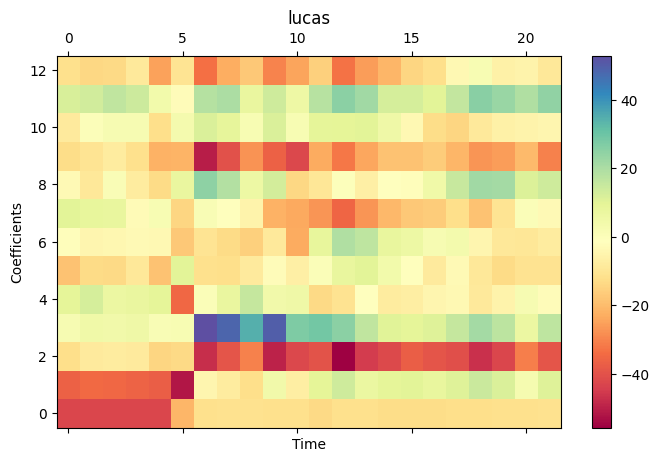

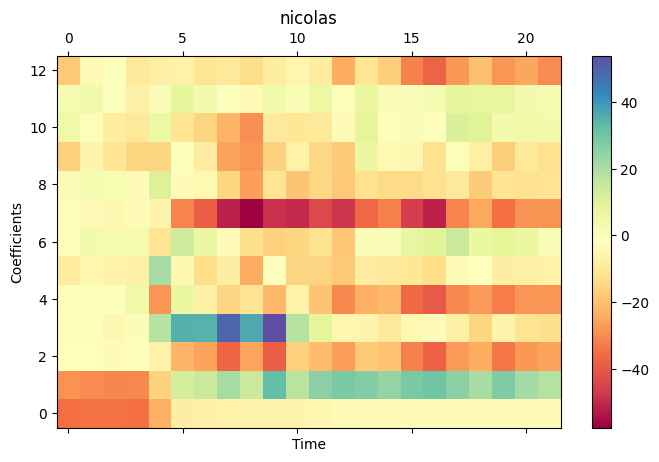

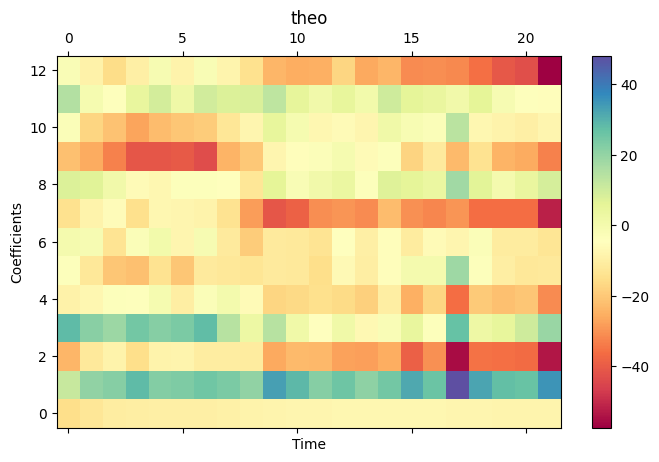

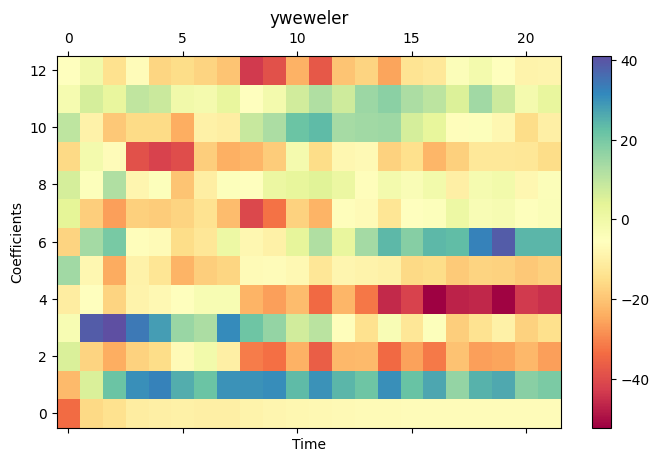

In [ ]:
for speaker_name in mfcc_dic_speaker.keys():
    plt.matshow(mfcc_dic_speaker[speaker_name][499].T, cmap='Spectral',origin='lower', aspect='auto')
    plt.title(f"{speaker_name}")
    plt.ylabel('Coefficients')
    plt.xlabel('Time')
    plt.colorbar()
    plt.show()

- <font size=4>robustness and sensitivity: MFCCs are sensitive to several characteristics of an audio signal. Few of them are:
    - Spectral Shape: MFCCs capture information about the spectral shape of the signal. Changes in the spectral envelope, such as variations in the energy distribution across different frequency bands, will affect the MFCCs.
    - Pitch: Variations in the fundamental frequency (pitch) of the signal can lead to changes in the spectral characteristics that MFCCs capture.
    - Vocal Tract Characteristics: Since MFCCs are based on the concept of the human vocal tract, changes in vocal tract characteristics (e.g., due to different speakers or speech conditions) can affect MFCC values. </font>

- <font size=4>usecase: Yes, there are some situations that MFCCs are not good at like Highly Noisy Environments, Non-speech Audio Analysis and Musical Audio Analysis</font>

- <font size=4>overlap: When calculating MFCCs, the frames used typically have some overlap to capture temporal information. This overlap allows for capture finer details of relationship between seprate frames.</font>

- <font size=4>We use only first 12 or 13 MFCCs for two reason:
    - Reducing the dimensionality of our feature space, which reduce the time complexity.
    - In the process of creating MFCCs, we use Discrete Cosine Transform (DCT). One DCT property is that it de-correlates and keeps most of the information in first few coefficients.</font>

<font size=6 color = "#663399" >Introduction with HMM</font>

- States and Observations: Value of the variable we are looking for at a given time is called the state. You observe outputs (effects) at each time step that are called observations. In this problem, each `state` specifies some feature of the audio. It actually keeps track of more complex features than the initially calculated ones, and it is somehow a combination of them. The `observations` are the MFCCs that we extracted earlier.

- <font size=4> First Order HMM: In a first-order HMM, the probability of transitioning from one hidden state to another depends only on the current state and not on any previous states. It is named "first-order" because each state depends only on one previous state(the next state is independent of all states given the current state). 
In other models in this category, the transition probabilities are allowed to depend on multiple previous states. </font>

- <font size=4> Applications of HMMs: HMMs are particularly effective for modeling and analyzing sequential data in situations where the underlying system has hidden states. This is because HMMs utilize states that are interconnected, and each state is associated with specific observations. The model is trained based on a sequence of observations, making it highly dependent on the order of the observation sequence.

    Some applications of HMM are as follows:
    * Speech recognition
    * Natural Language Processing (NLP)
    * Computer Vision </font>

- <font size=4> Pros and Cons: 

    **Pros:**
    1- Flexibility: HMMs can model a wide range of sequential data where the underlying process is assumed to be a Markov process with hidden states.
    2- Effective in Handling Uncertainty 
    3- Efficient learnings can take place from raw sequence data.
    
    **Cons:**
    1- Assumption of Stationarity: HMMs assume that the underlying process is stationary, meaning that the transition probabilities between hidden states do not change over time. 
    2-Limited Modeling Capacity: While HMMs are effective in capturing dependencies within sequences, they have limitations in modeling complex relationships and interactions between variables. 
    3-HMMs may struggle to capture long-term dependencies in data due to the limited memory provided by the Markov assumption.</font>

- <font size=4> Different Types of HMMs: 

1. **Discrete HMM (DHMM)**:
    - In a Discrete HMM, both the hidden states and the observable outputs are discrete. This type of HMM is often used when dealing with categorical data.

2. **Continuous HMM (CHMM)**:
    - In a Continuous HMM, the observable outputs are continuous variables. This type of HMM is commonly employed in applications where the data is best represented by 
    continuous values.

3. **Left-Right HMM:**
    - Left-Right HMMs are a specific type of HMM where transitions only occur from left to right in the state sequence. This structure is often used in modeling processes with a natural temporal order, such as speech signals.

4. **Factorial HMM (FHMM):**
    - FHMMs model dependencies among multiple sequences of observations. They are designed to capture interactions and correlations among different data streams.

<font size=4>Data Splitting: We split the dataset into training data and test data.</font>

In [ ]:
def reshape_list(input_list):
    output_list = []
    for sublist in input_list:
        reshaped_sublist = []
        for subsublist in sublist:
            reshaped_sublist.extend(subsublist)
        output_list.append(reshaped_sublist)
    return output_list

def transpose_array(arr):

    rows = len(arr)
    cols = len(arr[0])

    transposed_arr = [[0 for _ in range(rows)] for _ in range(cols)]

    for i in range(rows):
        for j in range(cols):
            transposed_arr[j][i] = arr[i][j]

    return transposed_arr

In [ ]:
test_size = 0.2

num_labels = list(mfcc_dic_num.keys())
num_data = list(mfcc_dic_num.values())

reshaped_list_num_data = reshape_list(num_data)
reshaped_list_num_data_t = transpose_array(reshaped_list_num_data[0])

# X_train_num, X_test_num, Y_train_num, Y_test_num = train_test_split(reshaped_list_num_data_t, [0], test_size = test_size, random_state = 42)

# reshaped_transposed = transpose_array(reshaped_list_num_data)

# X_train_num, X_test_num, Y_train_num, Y_test_num = train_test_split(reshaped_transposed, num_labels, test_size = test_size, random_state = 42)

# reshaped_transposed_list_num_data = transpose_array(reshaped_list_num_data[0])

# speaker_labels = list(mfcc_dic_speaker.keys())
# speaker_data = list(mfcc_dic_speaker.values())
# correct = 0
# total = 0

# model = GaussianHMM(n_components = 10, covariance_type = 'diag')
# model.fit(X_train_num)
# hmm_models_num.append(model) 

# predictions_num = []
# scores = []

# for number in range(10):
#     scores.append(hmm_models_num[number].score(X_test_num))
#     predicted_num = max(scores, key = scores.get)
#     predictions_num.append(predicted_num) 

#     if(predicted_num == number):
#         correct += 1
#     total += 1

# print("accuracy: ", correct / total)


# X_train_speaker, X_test_speaker, Y_train_speaker, Y_test_speaker = train_test_split(speaker_data, speaker_labels, test_size = test_size, random_state = 42)

In [ ]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:,0] = self.initial_prob[:,0] * observation_matrix[:,0]
            else:
                alpha[:,t] = np.matmul(self.transition_matrix.T,alpha[:,t-1]) * observation_matrix[:,t]
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] =  np.matmul(self.transition_matrix,(observation_matrix[:,t+1] * beta[:,t+1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T,mean =self.mean[:,s],cov = self.covariances[:,:,s])

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]
        B = self._state_likelihood(obs)
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = np.matmul(alpha[:,t],(beta[:,t+1].T*B[:,t+1].T))*self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:,t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:,T-1] * beta[:,T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = np.reshape(gamma[:, 0],(-1,1))
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum,axis=(0,1)))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=10):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


In [ ]:
hmm_models = []

## TODO 
# Iterate through each unique genre in the training data
# extract features from the audio files, and train a HMM for
# each genre, storing the trained models in the hmm_models list.


In [ ]:
## TODO
# In this section, iterate through the audio files, extract
# features, and use the trained HMMs to predict the genre
# for each audio file

<font size=6 color = "#663399" >Measuring the model</font>

- Measures (Q1 & Q3):

    - Acuuracy measures the proportion of correct predictions in the model.

        $Accuracy = \frac{True Predictions}{All Predictions}$

    - for each class precision is the proportion of the true positive predictions out of all positive-predicted data.

        $Precision = \frac{True Positive}{True Positive + False Positive}$

    - recall is the proportion of true positive predictions out of actually positive data.

        $Recall = \frac{True Positive}{True Positive + False Negative}$

    - F1 score is a balanced evaluation of Recall and precision and shows performance of the model. F1 score has a  value between 0 and 1.

        $F1  = 2* \frac{Recall * Precision}{Recall + Precision}$

- Multi class (Q2): Yes. for example, Acuuracy may not be enough because in multiclass classification, our prediction on some classes are really good but our model is predictiong one class horribly.

- Precision & Recall (Q4): Precision shows  portion of  positive preidicted data over all positive predicted samples. On the other side Recall shows portion of our positive predicted data over all trully positive data. For example if we have set of 10 data that 7 of them are positive and our model predict all of them positive, then our Precision is 0.7 but our Recall is 1 and with only Recall we would have thought that our model is doing perfect. On the other side if we have 10 samples that 7 of them are positive and our model predict one of these 7 positive and all other 9 negative then we wont have any False Positive prediction and our Precision is 1 but our Recall will be 0.14 So we need both of these metrics.

- F1 (Q5):  F1 score gives a harmonic importance to both Recall and Precision. This calculation is especially decent in imbalance datasets where the portion of negative and positive samples are not balanced. Furthuremore because of harmonic mean calculation F1 is less sensitive to exrtreme and noisy data.


<font size=6 color = "#663399" >First approach faild, another approach!</font>

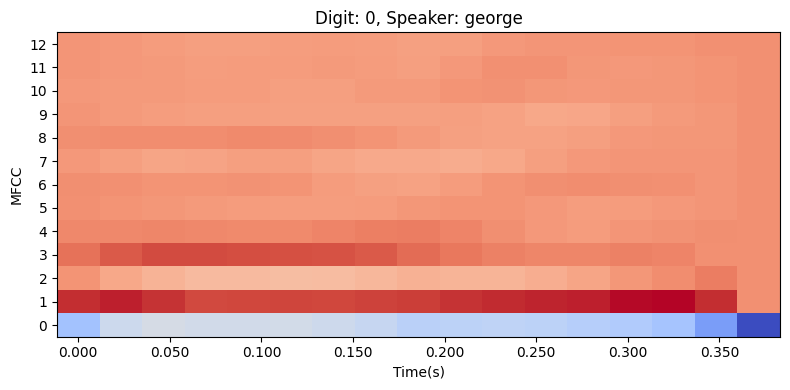

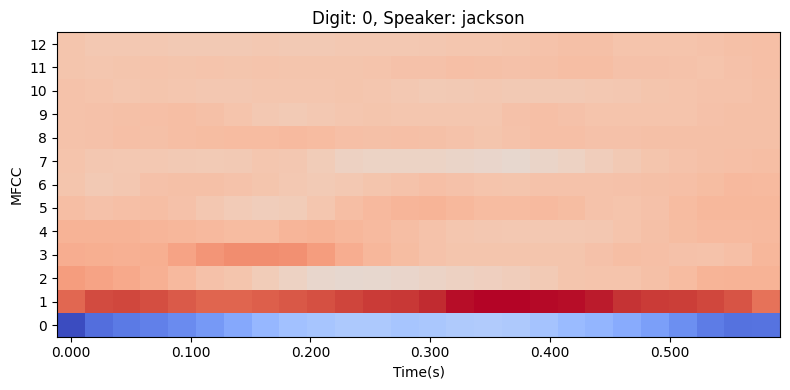

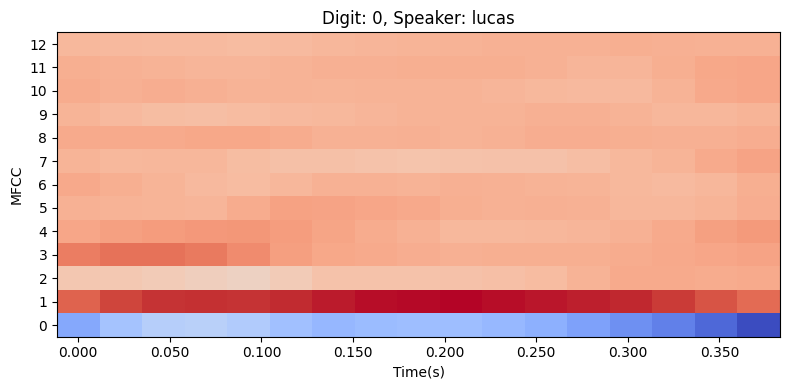

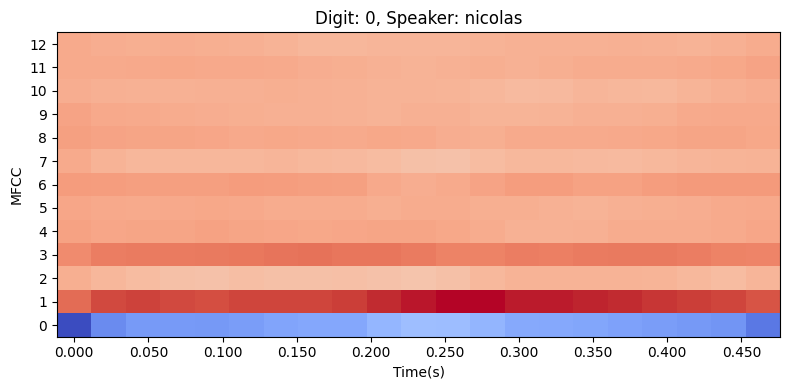

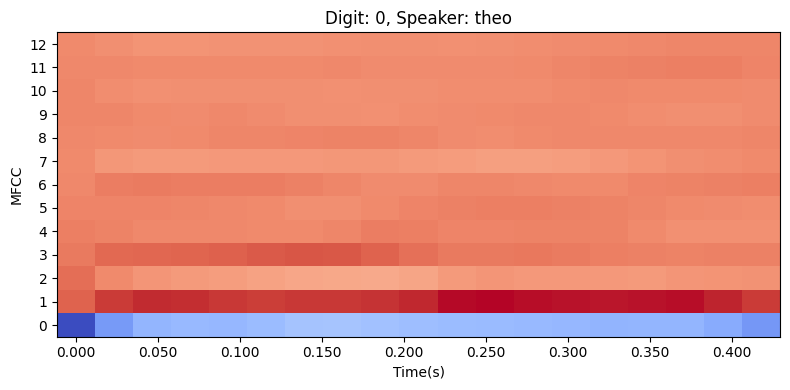

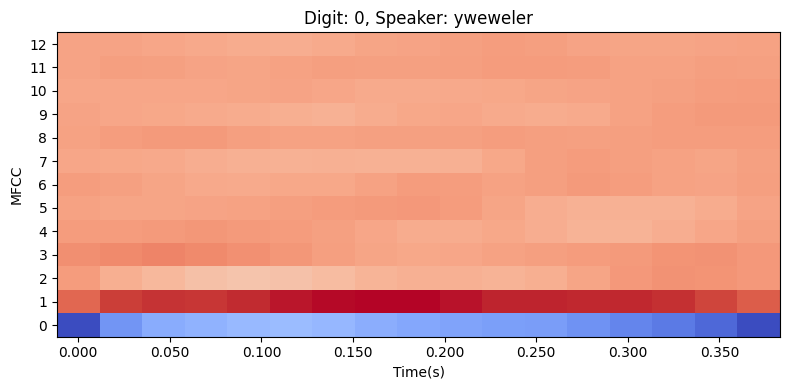

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random
from hmmlearn import hmm
import numpy as np
from collections import defaultdict
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from math import floor
from sklearn.preprocessing import normalize

recordingsDir = './recordings'
speakerMfccs = {}

for filename in os.listdir(recordingsDir):
    if filename.endswith('.wav'):
        filePath = os.path.join(recordingsDir, filename)
        audio, sampleRate = librosa.load(filePath)
        audioTrimmed, _ = librosa.effects.trim(audio, top_db=20)
        mfcc = librosa.feature.mfcc(y=audioTrimmed, sr=sampleRate, n_mfcc=13)
        speakerMfccs[filename] = (mfcc, sampleRate)
        
def plotMfcc(mfccs, sr, filename):
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.xlabel('Time(s)')
    plt.ylabel('MFCC')
    plt.yticks(range(0, 13))
    parts = filename.split('_')
    if len(parts) >= 3:
        title = f"Digit: {parts[0]}, Speaker: {parts[1]}"
    else:
        title = filename
    plt.title(title)
    plt.tight_layout()
    plt.show()

plottedSpeakers = set()

for filename, (mfcc, sr) in speakerMfccs.items():
    _, speakerName, _ = filename.rsplit('_', 2)
    if speakerName not in plottedSpeakers:
        plotMfcc(mfcc, sr, filename)
        plottedSpeakers.add(speakerName)

In [ ]:
recordingsByDigit = defaultdict(list)
recordingsBySpeaker = defaultdict(list)

for filename, (mfcc, sr) in speakerMfccs.items():
    splitedFilename = filename.split('_')
    digit = splitedFilename[0]
    speaker = splitedFilename[1]
    recordingsByDigit[digit].append((filename, (mfcc, sr)))
    recordingsBySpeaker[speaker].append((filename, (mfcc, sr)))

train_split_ratio = 0.8
trainSpeakerMFCC = {}
testSpeakerMFCC = {}

for _, recordings in recordingsByDigit.items():
    random.shuffle(recordings)
    numTrain = int(len(recordings) * train_split_ratio)

    trainRecordings = recordings[:numTrain]
    testRcordings = recordings[numTrain:]

    for filename, data in trainRecordings:
        trainSpeakerMFCC[filename] = data
    for filename, data in testRcordings:
        testSpeakerMFCC[filename] = data

digitModels = {}
speakerModels = {}
mfccsBySpeaker = defaultdict(list)

for filename, (mfcc, sr) in trainSpeakerMFCC.items():
    _, speakerName, _ = filename.rsplit('_', 2)
    mfccsBySpeaker[speakerName].append((mfcc, sr))

for digit in range(10):
    model = hmm.GaussianHMM(n_components=10, covariance_type="diag", n_iter=20)
    X = np.array([]).reshape(-1, 13)
    lengths = []

    for speakerName, (mfcc, sr) in trainSpeakerMFCC.items():
        if speakerName.startswith(str(digit)):
            if X.size == 0:
                X = mfcc.T
            else:
                X = np.vstack((X, mfcc.T))
            lengths.append(mfcc.shape[1])

    model.fit(X, lengths)
    digitModels[digit] = model

for speakerName, mfccs_sr_list in mfccsBySpeaker.items():
    model = hmm.GaussianHMM(n_components=10, covariance_type="diag", n_iter=20)
    X = np.array([]).reshape(-1, 13)
    lengths = []
    
    for mfcc, sr in mfccs_sr_list:
        if X.size == 0:
            X = mfcc.T
        else:
            X = np.vstack((X, mfcc.T))
        lengths.append(mfcc.shape[1])

    model.fit(X, lengths)
    speakerModels[speakerName] = model


Accuracy Digits: 0.96  Accuracy Speakers: 0.97

Precision Digits:
Digit 0: 0.95
Digit 1: 1.00
Digit 2: 0.95
Digit 3: 0.93
Digit 4: 0.98
Digit 5: 0.98
Digit 6: 1.00
Digit 7: 0.98
Digit 8: 0.89
Digit 9: 0.97

Precision Speakers:
Speaker yweweler: 0.96
Speaker theo: 0.95
Speaker george: 0.97
Speaker jackson: 0.96
Speaker nicolas: 1.00
Speaker lucas: 1.00


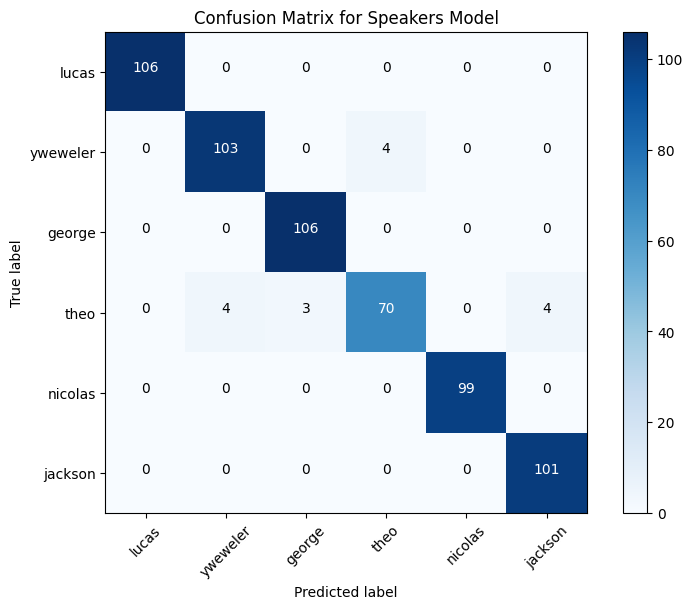

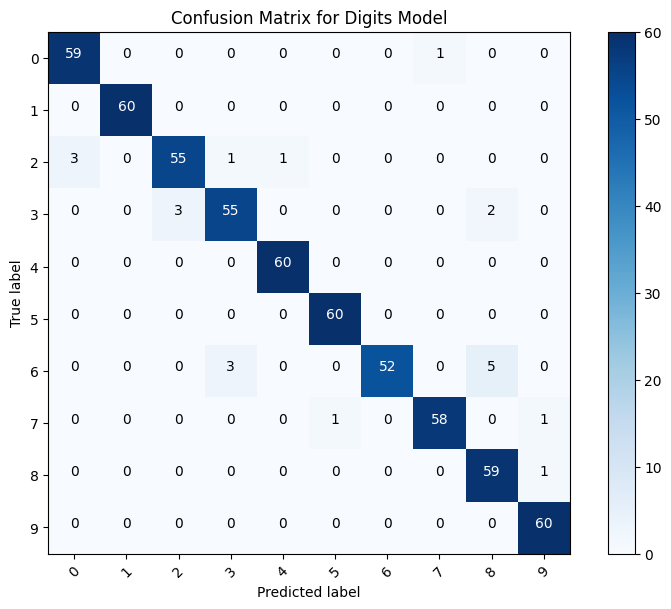

In [ ]:
def predictDigit(models, mfcc):
    bestScore, bestDigit = float("-inf"), None
    for digit, model in models.items():
        score = model.score(mfcc.T)
        if score > bestScore:
            bestScore, bestDigit = score, digit
    return bestDigit

def predictSpeaker(speakerModels, mfcc):
    bestScore, best_speaker = float("-inf"), None
    for speaker, model in speakerModels.items():
        score = model.score(mfcc.T)
        if score > bestScore:
            bestScore, best_speaker = score, speaker
    return best_speaker

correctPredictionsDigits = 0
correctPredictionsSpeakers = 0
totalTestSamples = len(testSpeakerMFCC)

true_positives_digits = {digit: 0 for digit in digitModels.keys()}
false_positives_digits = {digit: 0 for digit in digitModels.keys()}
true_positives_speakers = {speaker: 0 for speaker in speakerModels.keys()}
false_positives_speakers = {speaker: 0 for speaker in speakerModels.keys()}

for testFilename, (testMfcc, testSr) in testSpeakerMFCC.items():
    predictedDigit = predictDigit(digitModels, testMfcc)
    predictedSpeaker = predictSpeaker(speakerModels, testMfcc)

    actualDigit = int(testFilename.split('_')[0])
    actualSpeaker = testFilename.split('_')[1]

    if predictedDigit == actualDigit:
        correctPredictionsDigits += 1
        true_positives_digits[predictedDigit] += 1
    else:
        false_positives_digits[predictedDigit] += 1

    if predictedSpeaker == actualSpeaker:
        correctPredictionsSpeakers += 1
        true_positives_speakers[predictedSpeaker] += 1
    else:
        false_positives_speakers[predictedSpeaker] += 1

accuracyDigits = correctPredictionsDigits / totalTestSamples
accuracySpeakers = correctPredictionsSpeakers / totalTestSamples

print(f"\nAccuracy Digits: {accuracyDigits:.2f}  Accuracy Speakers: {accuracySpeakers:.2f}")

precision_digits = {}
for digit in digitModels.keys():
    true_positive = true_positives_digits[digit]
    false_positive = false_positives_digits[digit]
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    precision_digits[digit] = precision

precision_speakers = {}
for speaker in speakerModels.keys():
    true_positive = true_positives_speakers[speaker]
    false_positive = false_positives_speakers[speaker]
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    precision_speakers[speaker] = precision

print("\nPrecision Digits:")
for digit, precision in precision_digits.items():
    print(f"Digit {digit}: {precision:.2f}")

print("\nPrecision Speakers:")
for speaker, precision in precision_speakers.items():
    print(f"Speaker {speaker}: {precision:.2f}")

def calculate_confusion_matrix(true_labels, predicted_labels, num_classes):
    confusion_matrix = [[0] * num_classes for _ in range(num_classes)]
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        confusion_matrix[true_label][predicted_label] += 1
    return confusion_matrix


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def map_labels_to_indices(labels):
    label_to_index = {}
    index = 0
    for label in labels:
        if label not in label_to_index:
            label_to_index[label] = index
            index += 1
    return label_to_index

true_labels_digits = [int(testFilename.split('_')[0]) for testFilename in testSpeakerMFCC.keys()]
predicted_labels_digits = [predictDigit(digitModels, testMfcc) for testMfcc, _ in testSpeakerMFCC.values()]

true_labels_speakers = [testFilename.split('_')[1] for testFilename in testSpeakerMFCC.keys()]
predicted_labels_speakers = [predictSpeaker(speakerModels, testMfcc) for testMfcc, _ in testSpeakerMFCC.values()]


label_to_index = map_labels_to_indices(set(true_labels_speakers + predicted_labels_speakers))


true_labels_speakers_indices = [label_to_index[label] for label in true_labels_speakers]
predicted_labels_speakers_indices = [label_to_index[label] for label in predicted_labels_speakers]

class_names_digits = [str(digit) for digit in digitModels.keys()]

confusion_matrix_speakers = calculate_confusion_matrix(true_labels_speakers_indices, predicted_labels_speakers_indices, num_classes=len(label_to_index))

confusion_matrix_digits = calculate_confusion_matrix(true_labels_digits, predicted_labels_digits, num_classes=len(digitModels))

confusion_matrix_speakers = np.array(confusion_matrix_speakers)
confusion_matrix_digits = np.array(confusion_matrix_digits)


plt.figure(figsize=(8, 6))
plot_confusion_matrix(confusion_matrix_speakers, classes=label_to_index.keys(), title='Confusion Matrix for Speakers Model')

plt.figure(figsize=(8, 6))
plot_confusion_matrix(confusion_matrix_digits, classes=digitModels.keys(), title='Confusion Matrix for Digits Model')

plt.show()